In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=bacc6559f93d8f0a44cb08a586bee740a123cbcb14e8b0133c67154a8b48ad10
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [38]:
import json
import math
import os
import urllib.request
import warnings
from urllib.error import HTTPError

import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
sns.set()

In [41]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


In [9]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))


class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()


class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)


class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)


class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [39]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [10]:
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

In [11]:
def get_grads(act_fn, x):
    """Computes the gradients of an activation function at specified positions.

    Args:
        act_fn: An object of the class "ActivationFunction" with an implemented forward pass.
        x: 1D input tensor.

    Returns:
        A tensor with the same size of x containing the gradients of act_fn at x.

    """
    x = x.clone().requires_grad_()  # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward()  # Summing results in an equal gradient flow to each element in x
    return x.grad 

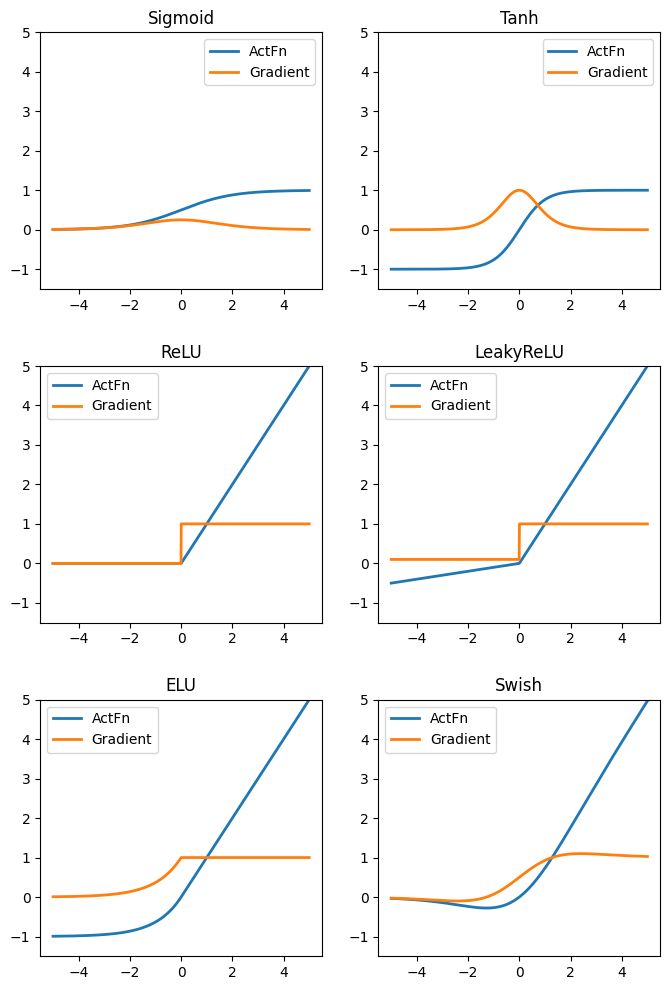

In [14]:
import torch 
import matplotlib.pyplot as plt
import math

def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    # Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())


# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000)  # Range on which we want to visualize the activation functions
# Plotting
cols = 2
rows = math.ceil(len(act_fns) / float(cols))
fig, ax = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i, cols)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

In [30]:
from torchvision.datasets import  FashionMNIST
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = FashionMNIST(root='./', train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root='./', train=False, transform=transform, download=True)

In [33]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

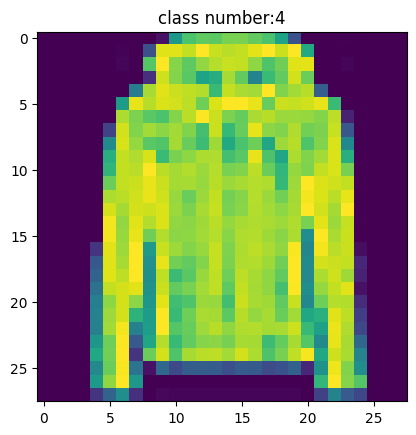

In [4]:
import matplotlib.pyplot as plt
import random

rand_num = random.randint(0, 60000)
plt.title("class number:" + str(train_set[rand_num][1]))
plt.imshow(train_set[rand_num][0])

In [23]:
train_set[rand_num][0]

In [17]:
from torch import nn

class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """Base Network.

        Args:
            act_fn: Object of the activation function that should be used as non-linearity in the network.
            input_size: Size of the input images in pixels
            num_classes: Number of classes we want to predict
            hidden_sizes: A list of integers specifying the hidden layer sizes in the NN

        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        layer_size_last = layer_sizes[0]
        for layer_size in layer_sizes[1:]:
            layers += [nn.Linear(layer_size_last, layer_size), act_fn]
            layer_size_last = layer_size
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # nn.Sequential summarizes a list of modules into a single module, applying them in sequence
        self.layers = nn.Sequential(*layers)

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {
            "act_fn": act_fn.config,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Reshape images to a flat vector
        out = self.layers(x)
        return out

act_fn = act_fn_by_name['sigmoid']()
model = BaseNetwork(act_fn=act_fn)

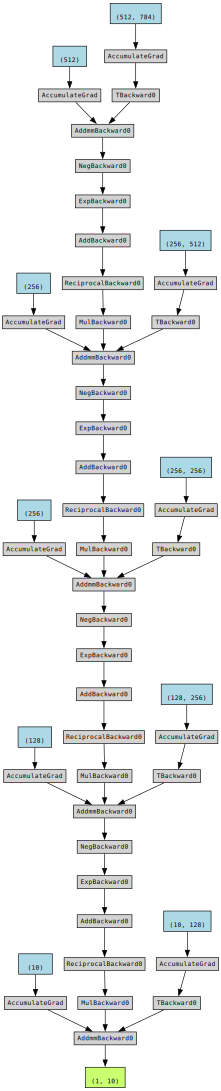

In [26]:
from torchviz import make_dot

first = train_set[0][0]
make_dot(model(first))

In [31]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")


def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")


def load_model(model_path, model_name, net=None):
    """Loads a saved model from disk.

    Args:
        model_path: Path of the checkpoint directory
        model_name: Name of the model (str)
        net: (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.

    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(
        config_file
    ), f'Could not find the config file "{config_file}". Are you sure this is the correct path and you have your model config stored here?'
    assert os.path.isfile(
        model_file
    ), f'Could not find the model file "{model_file}". Are you sure this is the correct path and you have your model stored here?'
    with open(config_file) as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net


def save_model(model, model_path, model_name):
    """Given a model, we save the state_dict and hyperparameters.

    Args:
        model: Network object to save parameters from
        model_path: Path of the checkpoint directory
        model_name: Name of the model (str)

    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

In [34]:
def visualize_gradients(net, color="C0"):
    """Visualize gradients.

    Args:
        net: Object of class BaseNetwork
        color: Color in which we want to visualize the histogram (for easier separation of activation functions)

    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {
        name: params.grad.data.view(-1).cpu().clone().numpy()
        for name, params in net.named_parameters()
        if "weight" in name
    }
    net.zero_grad()

    # Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index % columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(
        f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05
    )
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

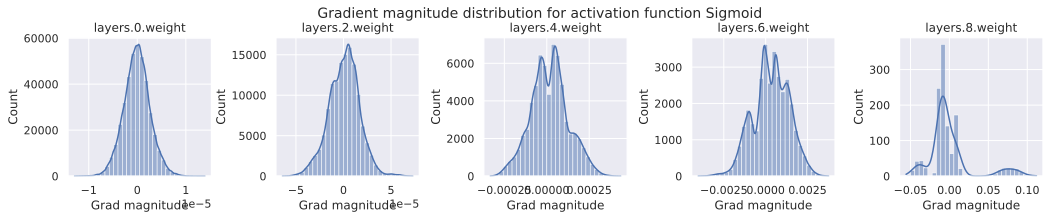

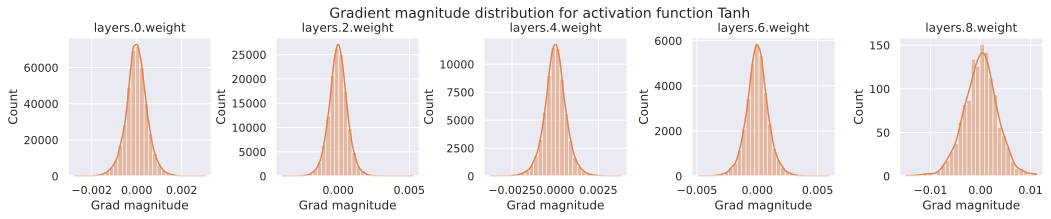

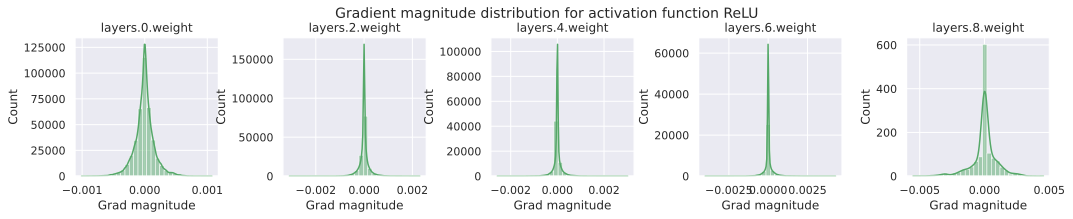

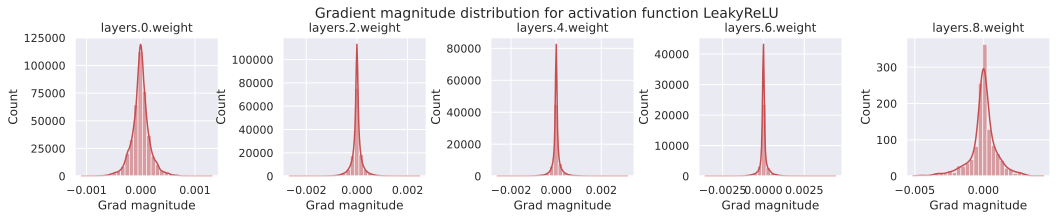

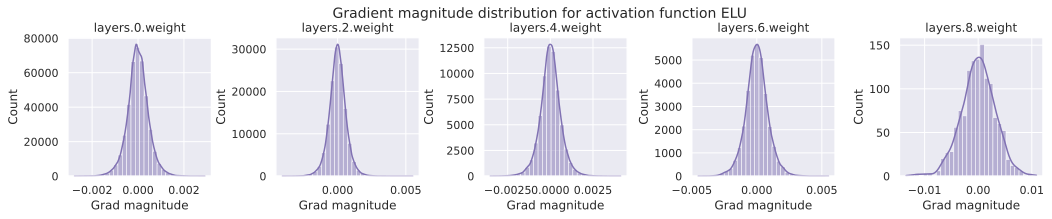

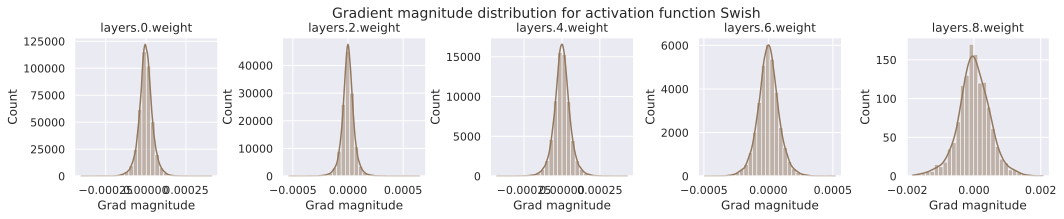

In [42]:
import warnings
warnings.filterwarnings("ignore")
# Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    # Setting the seed ensures that we have the same weight initialization for each activation function
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

In [49]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """Train a model on the training set of FashionMNIST.

    Args:
        net: Object of BaseNetwork
        model_name: (str) Name of the model, used for creating the checkpoint names
        max_epochs: Number of epochs we want to (maximally) train for
        patience: If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size: Size of batches used in training
        overwrite: Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.

    """
    file_exists = os.path.isfile(_get_model_file('./', model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)  # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(
            train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True
        )

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0.0, 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)  # To GPU
                optimizer.zero_grad()  # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(
                f"[Epoch {epoch+1}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%"
            )

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, './', model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model('./', model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=") + "\n")
    return test_acc


def test_model(net, data_loader):
    """Test a model on a specified dataset.

    Args:
        net: Trained model of type BaseNetwork
        data_loader: DataLoader object of the dataset to test on (validation or test)

    """
    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

Training BaseNetwork with sigmoid activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 10.09%, Validation accuracy: 10.17%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 10.00%, Validation accuracy: 09.82%


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 10.03%, Validation accuracy: 10.31%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 09.93%, Validation accuracy: 10.17%


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 5] Training accuracy: 10.14%, Validation accuracy: 09.80%


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 6] Training accuracy: 09.99%, Validation accuracy: 09.65%


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 7] Training accuracy: 10.07%, Validation accuracy: 10.05%


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 8] Training accuracy: 10.09%, Validation accuracy: 10.22%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 9] Training accuracy: 09.99%, Validation accuracy: 09.80%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 10.23%, Validation accuracy: 09.82%
Early stopping due to no improvement over the last 7 epochs


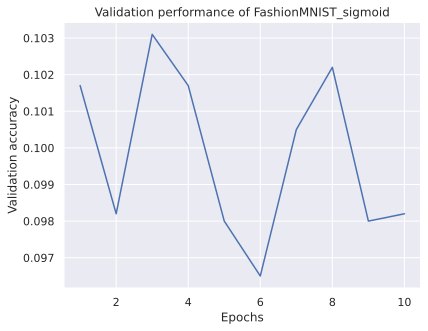

============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 66.30%, Validation accuracy: 78.08%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 81.52%, Validation accuracy: 82.21%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 83.77%, Validation accuracy: 84.32%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 85.12%, Validation accuracy: 84.60%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 5] Training accuracy: 85.87%, Validation accuracy: 85.65%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 6] Training accuracy: 86.37%, Validation accuracy: 85.65%


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 7] Training accuracy: 86.91%, Validation accuracy: 86.29%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 8] Training accuracy: 87.24%, Validation accuracy: 86.31%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 9] Training accuracy: 87.70%, Validation accuracy: 85.98%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 87.94%, Validation accuracy: 87.25%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 88.43%, Validation accuracy: 87.07%


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 88.75%, Validation accuracy: 87.29%
	   (New best performance, saving model...)


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 89.01%, Validation accuracy: 87.93%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 89.09%, Validation accuracy: 87.76%


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 89.48%, Validation accuracy: 87.90%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 89.58%, Validation accuracy: 88.44%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 89.86%, Validation accuracy: 87.76%


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 90.19%, Validation accuracy: 87.67%


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 90.13%, Validation accuracy: 86.92%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 90.70%, Validation accuracy: 88.71%
	   (New best performance, saving model...)


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 90.61%, Validation accuracy: 88.53%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 90.61%, Validation accuracy: 87.83%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 91.00%, Validation accuracy: 88.39%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 90.95%, Validation accuracy: 88.48%


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 91.39%, Validation accuracy: 88.42%


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 91.33%, Validation accuracy: 88.43%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 91.76%, Validation accuracy: 89.05%
	   (New best performance, saving model...)


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 91.90%, Validation accuracy: 89.01%


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 91.81%, Validation accuracy: 88.56%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 92.12%, Validation accuracy: 88.66%


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 91.93%, Validation accuracy: 88.63%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 92.52%, Validation accuracy: 87.46%


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 92.23%, Validation accuracy: 89.06%
	   (New best performance, saving model...)


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 92.71%, Validation accuracy: 87.84%


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 92.80%, Validation accuracy: 88.95%


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 92.90%, Validation accuracy: 88.89%


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 93.33%, Validation accuracy: 88.35%


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 93.23%, Validation accuracy: 89.06%


Epoch 39:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 93.54%, Validation accuracy: 89.24%
	   (New best performance, saving model...)


Epoch 40:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 40] Training accuracy: 93.32%, Validation accuracy: 88.78%


Epoch 41:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 41] Training accuracy: 93.64%, Validation accuracy: 89.02%


Epoch 42:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 42] Training accuracy: 93.79%, Validation accuracy: 88.42%


Epoch 43:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 43] Training accuracy: 93.90%, Validation accuracy: 88.78%


Epoch 44:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 44] Training accuracy: 94.03%, Validation accuracy: 88.15%


Epoch 45:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 45] Training accuracy: 94.42%, Validation accuracy: 89.17%


Epoch 46:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 46] Training accuracy: 94.23%, Validation accuracy: 88.54%
Early stopping due to no improvement over the last 7 epochs


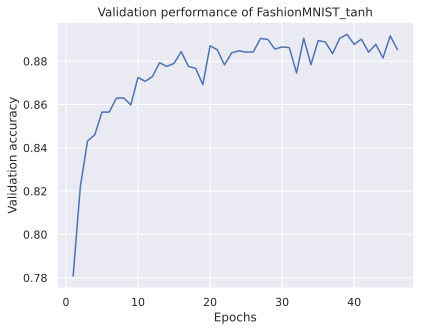

============= Test accuracy: 88.10% ==============

Training BaseNetwork with relu activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 49.07%, Validation accuracy: 73.96%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 78.75%, Validation accuracy: 81.11%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 82.98%, Validation accuracy: 83.52%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 84.93%, Validation accuracy: 84.49%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 5] Training accuracy: 86.04%, Validation accuracy: 85.54%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 6] Training accuracy: 87.10%, Validation accuracy: 86.26%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 7] Training accuracy: 87.55%, Validation accuracy: 87.32%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 8] Training accuracy: 88.29%, Validation accuracy: 86.95%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 9] Training accuracy: 88.66%, Validation accuracy: 87.54%
	   (New best performance, saving model...)


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 89.13%, Validation accuracy: 87.49%


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 89.84%, Validation accuracy: 87.76%
	   (New best performance, saving model...)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 90.08%, Validation accuracy: 87.69%


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 90.36%, Validation accuracy: 88.31%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 90.51%, Validation accuracy: 88.49%
	   (New best performance, saving model...)


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 90.85%, Validation accuracy: 88.61%
	   (New best performance, saving model...)


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 91.37%, Validation accuracy: 88.74%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 91.39%, Validation accuracy: 88.62%


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 91.64%, Validation accuracy: 88.98%
	   (New best performance, saving model...)


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 91.94%, Validation accuracy: 87.79%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 92.49%, Validation accuracy: 88.90%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 92.69%, Validation accuracy: 89.10%
	   (New best performance, saving model...)


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 92.84%, Validation accuracy: 88.36%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 92.91%, Validation accuracy: 88.03%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 92.73%, Validation accuracy: 88.50%


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 93.43%, Validation accuracy: 89.38%
	   (New best performance, saving model...)


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 93.65%, Validation accuracy: 89.17%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 93.84%, Validation accuracy: 89.02%


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 94.15%, Validation accuracy: 89.35%


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 94.40%, Validation accuracy: 88.47%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 94.63%, Validation accuracy: 89.13%


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 94.44%, Validation accuracy: 89.32%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 95.09%, Validation accuracy: 88.26%
Early stopping due to no improvement over the last 7 epochs


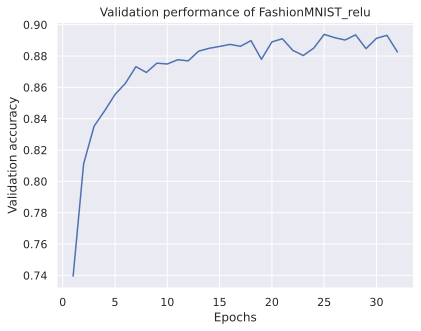

============= Test accuracy: 88.62% ==============

Training BaseNetwork with leakyrelu activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 50.13%, Validation accuracy: 74.72%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 79.18%, Validation accuracy: 81.41%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 82.99%, Validation accuracy: 83.56%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 84.79%, Validation accuracy: 84.59%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 5] Training accuracy: 85.90%, Validation accuracy: 85.20%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 6] Training accuracy: 86.93%, Validation accuracy: 86.01%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 7] Training accuracy: 87.32%, Validation accuracy: 86.74%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 8] Training accuracy: 87.92%, Validation accuracy: 86.97%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 9] Training accuracy: 88.34%, Validation accuracy: 87.23%
	   (New best performance, saving model...)


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 88.69%, Validation accuracy: 87.54%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 89.40%, Validation accuracy: 87.58%
	   (New best performance, saving model...)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 89.61%, Validation accuracy: 87.67%
	   (New best performance, saving model...)


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 89.93%, Validation accuracy: 88.27%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 89.93%, Validation accuracy: 88.41%
	   (New best performance, saving model...)


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 90.43%, Validation accuracy: 88.30%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 90.71%, Validation accuracy: 88.45%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 90.96%, Validation accuracy: 88.01%


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 91.24%, Validation accuracy: 88.58%
	   (New best performance, saving model...)


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 91.35%, Validation accuracy: 88.17%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 91.89%, Validation accuracy: 88.73%
	   (New best performance, saving model...)


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 92.09%, Validation accuracy: 88.97%
	   (New best performance, saving model...)


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 92.07%, Validation accuracy: 88.52%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 92.40%, Validation accuracy: 88.28%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 92.29%, Validation accuracy: 88.77%


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 92.82%, Validation accuracy: 89.06%
	   (New best performance, saving model...)


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 93.02%, Validation accuracy: 89.12%
	   (New best performance, saving model...)


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 93.28%, Validation accuracy: 88.92%


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 93.49%, Validation accuracy: 89.23%
	   (New best performance, saving model...)


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 93.79%, Validation accuracy: 89.64%
	   (New best performance, saving model...)


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 93.66%, Validation accuracy: 88.89%


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 93.77%, Validation accuracy: 89.27%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 94.43%, Validation accuracy: 88.24%


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 94.28%, Validation accuracy: 89.05%


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 94.34%, Validation accuracy: 88.53%


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 94.87%, Validation accuracy: 89.15%


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 94.52%, Validation accuracy: 88.30%
Early stopping due to no improvement over the last 7 epochs


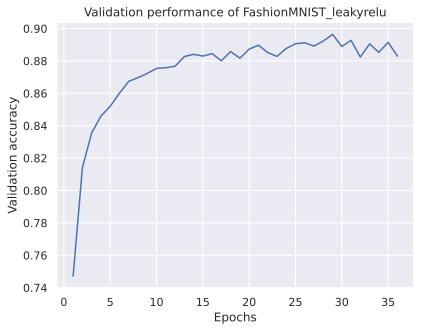

============= Test accuracy: 88.28% ==============

Training BaseNetwork with elu activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 66.06%, Validation accuracy: 78.07%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 81.50%, Validation accuracy: 82.55%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 83.92%, Validation accuracy: 84.01%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 84.93%, Validation accuracy: 84.53%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 5] Training accuracy: 85.76%, Validation accuracy: 85.10%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 6] Training accuracy: 86.03%, Validation accuracy: 85.56%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 7] Training accuracy: 86.70%, Validation accuracy: 85.82%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 8] Training accuracy: 87.03%, Validation accuracy: 86.72%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 9] Training accuracy: 87.34%, Validation accuracy: 86.06%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 87.59%, Validation accuracy: 86.77%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 88.01%, Validation accuracy: 86.92%
	   (New best performance, saving model...)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 88.14%, Validation accuracy: 86.78%


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 88.45%, Validation accuracy: 87.50%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 88.40%, Validation accuracy: 87.63%
	   (New best performance, saving model...)


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 88.95%, Validation accuracy: 87.52%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 89.21%, Validation accuracy: 88.11%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 89.37%, Validation accuracy: 87.62%


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 89.69%, Validation accuracy: 87.55%


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 89.65%, Validation accuracy: 87.06%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 90.05%, Validation accuracy: 88.46%
	   (New best performance, saving model...)


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 90.17%, Validation accuracy: 88.30%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 89.89%, Validation accuracy: 87.40%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 90.29%, Validation accuracy: 88.23%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 90.31%, Validation accuracy: 88.62%
	   (New best performance, saving model...)


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 90.49%, Validation accuracy: 88.11%


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 90.71%, Validation accuracy: 88.12%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 91.00%, Validation accuracy: 88.70%
	   (New best performance, saving model...)


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 91.01%, Validation accuracy: 88.67%


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 91.01%, Validation accuracy: 88.12%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 91.29%, Validation accuracy: 88.29%


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 91.03%, Validation accuracy: 88.59%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 91.69%, Validation accuracy: 87.60%


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 91.50%, Validation accuracy: 88.79%
	   (New best performance, saving model...)


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 91.58%, Validation accuracy: 87.92%


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 91.95%, Validation accuracy: 88.91%
	   (New best performance, saving model...)


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 92.01%, Validation accuracy: 88.74%


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 92.19%, Validation accuracy: 87.99%


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 92.26%, Validation accuracy: 89.04%
	   (New best performance, saving model...)


Epoch 39:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 92.55%, Validation accuracy: 88.82%


Epoch 40:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 40] Training accuracy: 92.29%, Validation accuracy: 89.01%


Epoch 41:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 41] Training accuracy: 92.55%, Validation accuracy: 88.62%


Epoch 42:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 42] Training accuracy: 92.68%, Validation accuracy: 88.52%


Epoch 43:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 43] Training accuracy: 92.60%, Validation accuracy: 89.20%
	   (New best performance, saving model...)


Epoch 44:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 44] Training accuracy: 93.09%, Validation accuracy: 88.53%


Epoch 45:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 45] Training accuracy: 93.22%, Validation accuracy: 89.03%


Epoch 46:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 46] Training accuracy: 92.89%, Validation accuracy: 88.03%


Epoch 47:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 47] Training accuracy: 93.26%, Validation accuracy: 88.04%


Epoch 48:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 48] Training accuracy: 93.34%, Validation accuracy: 88.39%


Epoch 49:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 49] Training accuracy: 93.46%, Validation accuracy: 88.53%


Epoch 50:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 50] Training accuracy: 93.88%, Validation accuracy: 88.98%
Early stopping due to no improvement over the last 7 epochs


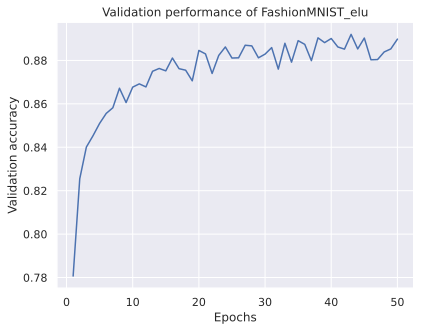

============= Test accuracy: 88.55% ==============

Training BaseNetwork with swish activation...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 1] Training accuracy: 26.33%, Validation accuracy: 33.80%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 2] Training accuracy: 64.52%, Validation accuracy: 75.51%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 3] Training accuracy: 79.26%, Validation accuracy: 80.88%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 4] Training accuracy: 82.68%, Validation accuracy: 82.81%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 5] Training accuracy: 83.81%, Validation accuracy: 83.38%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 6] Training accuracy: 85.04%, Validation accuracy: 84.57%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 7] Training accuracy: 85.64%, Validation accuracy: 85.30%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 8] Training accuracy: 86.03%, Validation accuracy: 85.70%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 9] Training accuracy: 86.45%, Validation accuracy: 84.51%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 86.90%, Validation accuracy: 86.15%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 87.21%, Validation accuracy: 86.47%
	   (New best performance, saving model...)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 87.44%, Validation accuracy: 86.31%


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 87.74%, Validation accuracy: 87.06%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 87.82%, Validation accuracy: 87.17%
	   (New best performance, saving model...)


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 88.42%, Validation accuracy: 87.25%
	   (New best performance, saving model...)


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 88.51%, Validation accuracy: 87.46%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 88.80%, Validation accuracy: 87.54%
	   (New best performance, saving model...)


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 89.09%, Validation accuracy: 87.42%


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 89.17%, Validation accuracy: 86.86%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 89.41%, Validation accuracy: 88.08%
	   (New best performance, saving model...)


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 89.40%, Validation accuracy: 88.04%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 89.58%, Validation accuracy: 87.33%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 89.71%, Validation accuracy: 88.52%
	   (New best performance, saving model...)


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 89.90%, Validation accuracy: 88.30%


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 90.04%, Validation accuracy: 88.34%


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 90.43%, Validation accuracy: 88.07%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 90.48%, Validation accuracy: 88.48%


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 90.63%, Validation accuracy: 88.66%
	   (New best performance, saving model...)


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 90.72%, Validation accuracy: 88.32%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 91.04%, Validation accuracy: 88.52%


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 91.02%, Validation accuracy: 89.23%
	   (New best performance, saving model...)


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 91.22%, Validation accuracy: 87.48%


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 91.23%, Validation accuracy: 88.88%


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 91.41%, Validation accuracy: 88.20%


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 91.63%, Validation accuracy: 88.97%


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 91.83%, Validation accuracy: 88.45%


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 91.99%, Validation accuracy: 88.23%


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 92.15%, Validation accuracy: 89.16%
Early stopping due to no improvement over the last 7 epochs


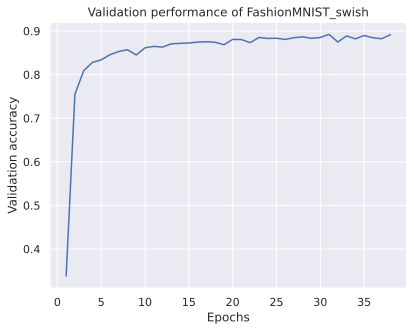

============= Test accuracy: 88.13% ==============



In [50]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

In [51]:
def visualize_activations(net, color="C0"):
    activations = {}

    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    # Plotting
    columns = 4
    rows = math.ceil(len(activations) / columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns * 2.7, rows * 2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index // columns][fig_index % columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

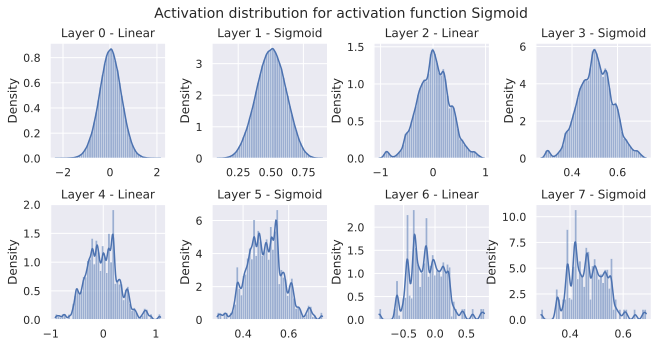

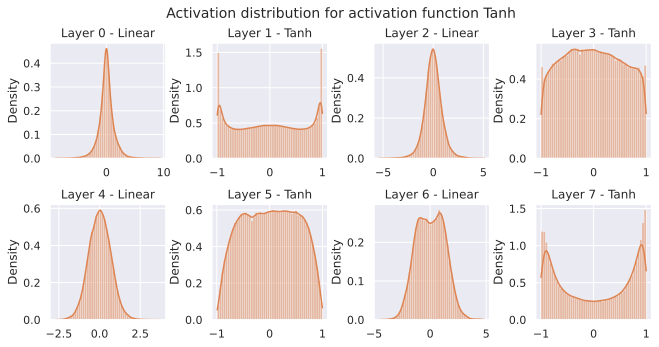

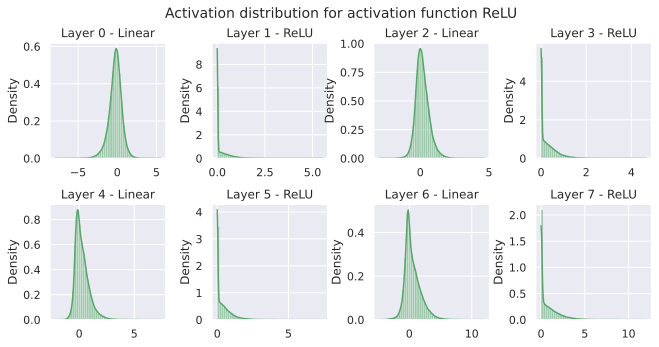

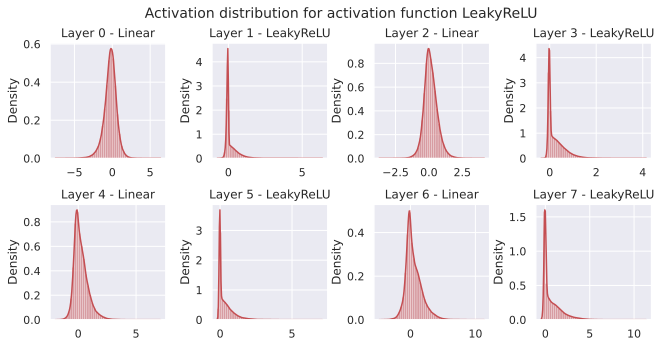

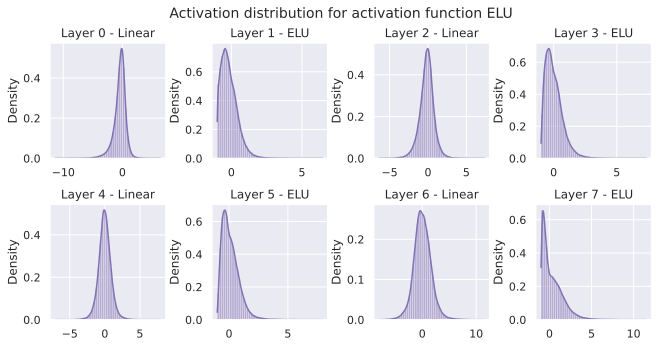

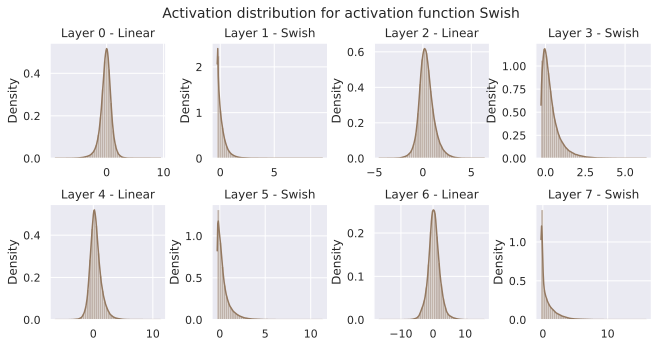

In [53]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path='./', model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

In [54]:
@torch.no_grad()
def measure_number_dead_neurons(net):
    """Function to measure the number of dead neurons in a trained neural network.

    For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time, we
    set this variable to 0. After running through the whole training set, only dead neurons will have a 1.

    """
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool)
        for layer in net.layers[:-1]
        if isinstance(layer, nn.Linear)
    ]  # Same shapes as hidden size in BaseNetwork

    net.eval()
    for imgs, labels in tqdm(train_loader, leave=False):  # Run through whole training set
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        for layer in net.layers[:-1]:
            imgs = layer(imgs)
            if isinstance(layer, ActivationFunction):
                # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
                neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print(
        "In percentage:",
        ", ".join(
            [f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]
        ),
    )

In [55]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 10]
In percentage: 0.00%, 0.00%, 1.17%, 7.81%


In [57]:
net_relu = load_model(model_path='./', model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 0, 1]
In percentage: 0.00%, 0.00%, 0.00%, 0.78%


In [58]:
set_seed(42)
net_relu = BaseNetwork(
    act_fn=ReLU(),
    hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128],
).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 8, 27, 89, 60, 58, 61, 72, 56]
In percentage: 0.00%, 0.00%, 3.12%, 10.55%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%
